# **Popular Fitness Youtube Channels**

Fetching data from the most popular fitness YouTube channels, in total : (15 youtube channels)..

All statistics about each channel : subscribers, number of videos, views, likes, comments..

In [13]:
import os 
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
import seaborn as sns
import warnings;
warnings.filterwarnings('ignore')
import re
import datetime
import random

### *Part 1 : collect and prepare data by using :  youtube v3 api*

In [86]:
api_key = ''
channel_ids = ['UCkk2vs5EXLFUMuVyhy7oOMQ',#@POPSUGARFitness
              'UCAxW1XT0iEJo0TYlRfn6rYQ',#@TheBodyCoachTV
              'UCIJwWYOfsCfz6PjxbONYXSg',#@blogilates
              'UCEtMRF1ywKMc4sf3EXYyDzw',#@ScottHermanFitness
              'UCFKE7WVJfvaHW5q283SxchA',#@yogawithadriene
              'UChVRfsT_ASBZk10o0An7Ucg',#@PamelaRf1
              'UCyqR7WkL8i1b6xtSssDmW9w',#@TheFitnessMarshall
              'CpQ34afVgk8cRQBjSJ1xuJQ', #@MadFit
              'UCM1Nde-9eorUhq-teaWlgUA',#@xhit
              'UCJ48BrODPTg4RJBLNIj9J1Q', #@kaylaitsines
              'UCCgLoMYIyP0U56dEhEL1wXQ',#@ChloeTing
              'UCiP6wD_tYlYLYh3agzbByWQ',#@fitnessblender
              'UC7aE5B-ZFEAoumyj6FaJ7lg',#@BradleyMartynOnline
              'UCnP_T4dI2JYG7BnH42PC9qw',#@joannasohofficial
              'UCeqR0F3O1V11CiiOaJbd1pw',#@MattDoesFitness
             'UCe0TLA0EsQbE-MjuHXevj2A']#@athleanx

youtube = build('youtube','v3', developerKey=api_key)

**Fetching channels data** : (channel id, playlist id, channel name, subscribers, views, total of videos)

In [87]:
def get_channel_func(youtube, channel_ids):
    my_list = []
    request = youtube.channels().list(part='snippet,contentDetails,statistics',id=','.join(channel_ids))
    response = request.execute()
    for index in range(len(response['items'])):
        data = dict(channel_id = response['items'][index]['id'],
               playlist_id = response['items'][index]['contentDetails']['relatedPlaylists']['uploads'],
               channel_name = response['items'][index]['snippet']['title'],
               subscribers = response['items'][index]['statistics']['subscriberCount'],
               total_views = response['items'][index]['statistics']['viewCount'],
               total_videos = response['items'][index]['statistics']['videoCount'])
        my_list.append(data)
    return my_list

In [88]:
channel_info = get_channel_func(youtube, channel_ids)

In [96]:
df_channels_info = pd.DataFrame(channel_info)

In [130]:
df_channels = pd.read_csv('All_channels_info.csv')
df_channels.shape

(15, 7)

In [92]:
playlist_ids = df_channels['playlist_id'].to_list()

playlist_ids[0:14]

['UUIJwWYOfsCfz6PjxbONYXSg',
 'UUeqR0F3O1V11CiiOaJbd1pw',
 'UUAxW1XT0iEJo0TYlRfn6rYQ',
 'UUCgLoMYIyP0U56dEhEL1wXQ',
 'UUkk2vs5EXLFUMuVyhy7oOMQ',
 'UUiP6wD_tYlYLYh3agzbByWQ',
 'UU7aE5B-ZFEAoumyj6FaJ7lg',
 'UUhVRfsT_ASBZk10o0An7Ucg',
 'UUe0TLA0EsQbE-MjuHXevj2A',
 'UUJ48BrODPTg4RJBLNIj9J1Q',
 'UUFKE7WVJfvaHW5q283SxchA',
 'UUyqR7WkL8i1b6xtSssDmW9w',
 'UUEtMRF1ywKMc4sf3EXYyDzw',
 'UUnP_T4dI2JYG7BnH42PC9qw']

**Fetching playlist videos ids for each channel** 

In [9]:
def get_playlist_func(youtube, playlist_id):
    
    request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlist_id,
        maxResults=50)
    response = request.execute()
    
    vids_ids = []
    
    for index in range(len(response['items'])):
        vids_ids.append(response['items'][index]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
        
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId=playlist_id,
                maxResults=50,
                pageToken=next_page_token)
            response = request.execute()
                
            for index in range(len(response['items'])):
                vids_ids.append(response['items'][index]['contentDetails']['videoId'])
                
        next_page_token = response.get('nextPageToken')
                
    return vids_ids

all_vids_ids = []

for pl_id in range(len(playlist_ids)):
            all_vids_ids.append(get_playlist_func(youtube, playlist_ids[pl_id]))
len(all_vids_ids)

15

In [10]:
#unpack first 10 elements of first list 
all_vids_ids[0][:10]

['ShAzpRE-SOY',
 'UNFB1g56AzQ',
 '8CVPN-o15lo',
 'lQtTgGzR7yg',
 'HWBVkkl2s1s',
 'c-2ADjt8euM',
 'YDtNkNh64ZI',
 'GUWZm1dA7T8',
 'byGf4V89b0I',
 '_8aRp-wumWc']

**Fetching data for all videos of each channels:** title, description, duration, caption, published date, ... , etc.

In [41]:
def get_vids_func(youtube, all_vids_ids):
    
    vids_stat = []
    
    for i in range(len(all_vids_ids)):
        for ii in range(0, len(all_vids_ids[i]), 50):
            try:
                request = youtube.videos().list(
                    part='snippet,contentDetails,statistics',
                    id=','.join(all_vids_ids[i][ii:ii+50]))
                response = request.execute()
                
                for video in response['items']:
                    vids_statistics = dict(Channel_id = video['snippet']['channelId'],
                                           Channel_name = video['snippet']['channelTitle'],
                                           Video_id = video['id'],
                                           Title = video['snippet']['title'],
                                           Description = video['snippet']['description'],
                                           Duration = video['contentDetails']['duration'],
                                           Definition = video['contentDetails']['definition'],
                                           Caption = video['contentDetails']['caption'],
                                           Published_at = video['snippet']['publishedAt'],
                                           Views = video['statistics']['viewCount'],
                                           Likes = video['statistics']['likeCount'],
                                           Comments = video['statistics']['commentCount'])
                    vids_stat.append(vids_statistics)
            except:
                print('failed to fetching data')
            
    return vids_stat

In [43]:
all_vids_details = get_vids_func(youtube, all_vids_ids)

In [66]:
len(all_vids_details)

14139

In [101]:
data_info = pd.DataFrame(all_vids_details)

In [2]:
channels_data = pd.read_csv('Channels_data.csv')
channels_data.shape

(14139, 13)

**Fetching 20 comments for all videos in each channel**

In [11]:
def get_comments_func(youtube, all_vids_ids):

    all_comments = []
    
    for i in range(len(all_vids_ids)):
        for j in range(len(all_vids_ids[i])):
            try:
                request = youtube.commentThreads().list(
                    part='snippet,replies',
                    videoId=all_vids_ids[i][j])
                response = request.execute()
                
                for comment in response['items']:
                    comments_info = {'Video_id' : all_vids_ids[i][j], 
                                     'Comments' : comment['snippet']['topLevelComment']['snippet']['textOriginal']}
                    all_comments.append(comments_info)
                    
            except: 
                error = f'failed to fetch data for video id : {all_vids_ids[i][j]}'
                print(error)
    
    return all_comments     

In [12]:
all_comment = get_comments_func(youtube, all_vids_ids)
len(all_comment)

failed to fetch data for video id : D4sfCqpbkfE
failed to fetch data for video id : HI_Sxhsxq_I
failed to fetch data for video id : sLBDPQ_mxEk
failed to fetch data for video id : Qitp8mEVHWI
failed to fetch data for video id : zNGHi2Nh1ww
failed to fetch data for video id : i_KaOlxA1pk
failed to fetch data for video id : j89aN0InPOc
failed to fetch data for video id : AHvyNXnf7C0
failed to fetch data for video id : xVApl9P6yFY
failed to fetch data for video id : HpmW4RQMnLI
failed to fetch data for video id : aDHl8U03_ag
failed to fetch data for video id : pl1WE1UYYwU
failed to fetch data for video id : 7iMvhX1qwRQ
failed to fetch data for video id : Bh9If0z6cvU
failed to fetch data for video id : nUmpaHTJoPk
failed to fetch data for video id : -d-fxVnlx-M
failed to fetch data for video id : vdxBqEN8blo
failed to fetch data for video id : uTCDVpesrdM
failed to fetch data for video id : k2WuxryRynw
failed to fetch data for video id : TxSBkRgBkcE
failed to fetch data for video id : 3G0U

60171

In [114]:
data_comments = pd.DataFrame(all_comment)

In [131]:
comments_data = pd.read_csv('Channels_comments.csv')
comments_data.shape

(60171, 3)

In [38]:
all_vids = []
for i in range(len(all_vids_ids)):
    for j in range(len(all_vids_ids[i])):
        all_vids.append(all_vids_ids[i][j])
len(all_vids)

15394

In [118]:
all_vids, success_vids = 15394 , 14139
all_comments, success_comments = success_vids * 20, len(all_comment)
diff_vids, diff_comments = all_vids - success_vids, all_comments - success_comments

result1 = f'Total number of video details we expected to capture is: {all_vids}, Total videos details which successfully captured is: {success_vids}, Total number of videos details we failed to captured is: {diff_vids}.'
result2 = f'\nTotal number of comments we expected to capture is: {all_comments}, Total comments we successfully captured is: {success_comments}, Total number of comments we failed to capture is: {diff_comments}'
print(result1, result2)

Total number of video details we expected to capture is: 15394, Total videos details which successfully captured is: 14139, Total number of videos details we failed to captured is: 1255. 
Total number of comments we expected to capture is: 282780, Total comments we successfully captured is: 60171, Total number of comments we failed to capture is: 222609


### *Part 2 : analyze data by using statistics, visualizations*

### All Channels - EDA

In [119]:
df_channels.head(2)

,Unnamed: 0,channel_id,playlist_id,channel_name,subscribers,total_views,total_videos
0,0,UCIJwWYOfsCfz6PjxbONYXSg,UUIJwWYOfsCfz6PjxbONYXSg,blogilates,8590000,2730969373,1177
1,1,UCeqR0F3O1V11CiiOaJbd1pw,UUeqR0F3O1V11CiiOaJbd1pw,MattDoesFitness,2210000,364196984,1379


In [165]:
df_channels.drop(columns = ['Unnamed: 0'], inplace=True)
df_channels.sample()

,channel_id,playlist_id,channel_name,subscribers,total_views,total_videos
8,UCe0TLA0EsQbE-MjuHXevj2A,UUe0TLA0EsQbE-MjuHXevj2A,ATHLEAN-X™,13300000,2304640671,1340


###  **Univariate Non-graphical Analysis**

In [126]:
df_channels.describe().T

,count,mean,std,min,25%,50%,75%,max
subscribers,15.0,6.542533e+06,6.384375e+06,415000.0,2800000.0,3230000.0,9.090000e+06,2.460000e+07
total_views,15.0,1.117635e+09,9.494515e+08,5699119.0,354123734.0,637827864.0,1.561254e+09,2.966597e+09
total_videos,15.0,1.043733e+03,7.667939e+02,97.0,555.0,887.0,1.359500e+03,3.169000e+03


**Ranking channels in term of its subscribers..**

In [127]:
filter1 = df_channels.loc[: ,['channel_name', 'subscribers']].sort_values(by='subscribers', ascending=False)
#Top 5 Channels by subscribers
filter1.head(5)

,channel_name,subscribers
3,Chloe Ting,24600000
8,ATHLEAN-X™,13300000
10,Yoga With Adriene,12000000
7,Pamela Reif,9590000
0,blogilates,8590000


 **Ranking channels in term of the views..**

In [128]:
filter2 = df_channels.loc[: ,['channel_name', 'total_views']].sort_values(by='total_views', ascending=False)
#Top 5 Channels by views
filter2.head(5)

,channel_name,total_views
3,Chloe Ting,2966596997
0,blogilates,2730969373
8,ATHLEAN-X™,2304640671
7,Pamela Reif,1730852425
11,The Fitness Marshall,1391655526


**Ranking channels in term of the uploaded videos..**

In [133]:
filter3 = df_channels.loc[: ,['channel_name', 'total_videos']].sort_values(by='total_videos', ascending=False)
#Top 5 Channels by uploaded videos
filter3.head(5)

,channel_name,total_videos
4,POPSUGAR,3169
12,ScottHermanFitness,1855
6,Bradley Martyn,1412
1,MattDoesFitness,1379
8,ATHLEAN-X™,1340


### **Univariate Graphical Analysis**

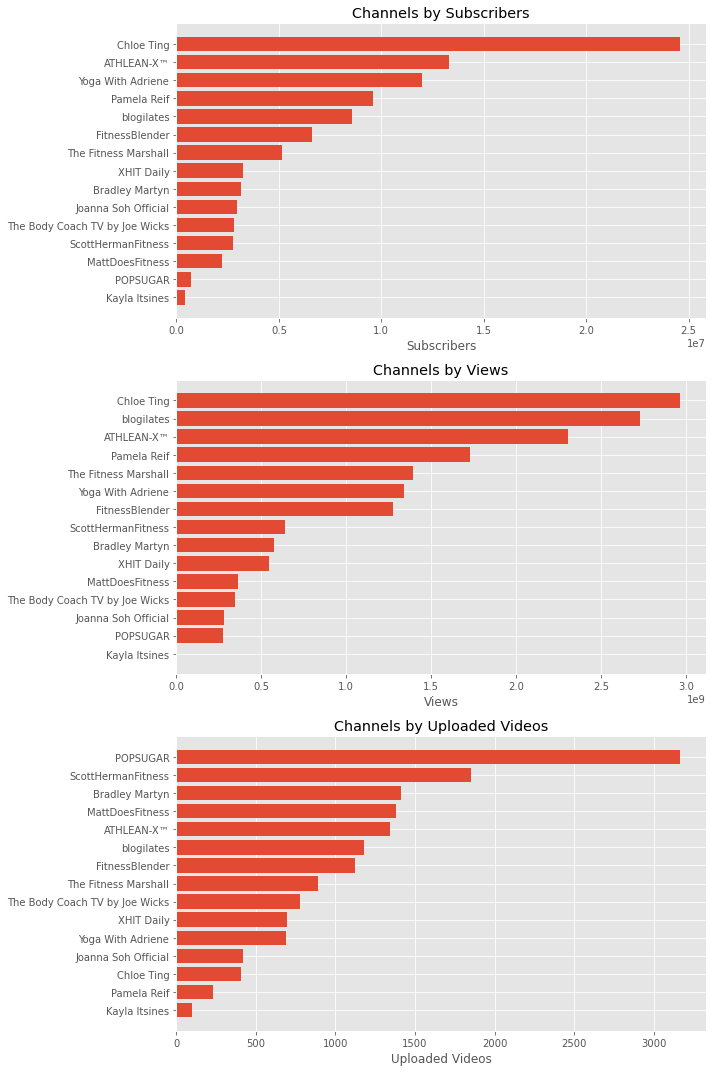

In [134]:
plt.style.use('ggplot')

fig , (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, figsize=(10, 15))

subscribers = df_channels.sort_values(by='subscribers', ascending=True)

ax1.barh( 'channel_name', 'subscribers', data=subscribers)

ax1.set_title('Channels by Subscribers')
ax1.set_xlabel('Subscribers')

views = df_channels.sort_values(by='total_views', ascending=True)

ax2.barh( 'channel_name', 'total_views', data=views)

ax2.set_title('Channels by Views')
ax2.set_xlabel('Views')

videos = df_channels.sort_values(by='total_videos', ascending=True)

ax3.barh( 'channel_name', 'total_videos', data=videos)

ax3.set_title('Channels by Uploaded Videos')
ax3.set_xlabel('Uploaded Videos')

plt.tight_layout()
plt.show()

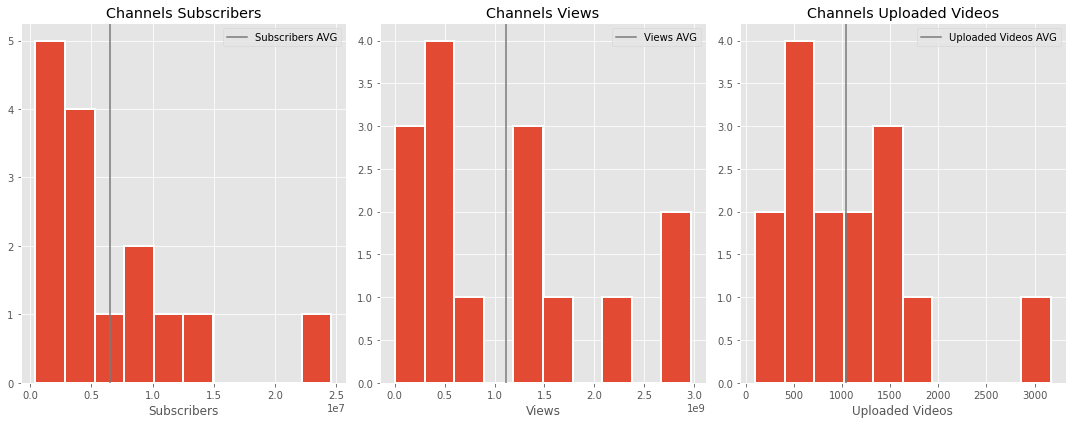

In [135]:
#pattern recognition
fig , (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize=(15,6))

color = '#7A7A7A'

subscriber_avg = int(np.mean(df_channels['subscribers']))

ax1.hist(df_channels['subscribers'], edgecolor='white', linewidth=2)

ax1.set_title('Channels Subscribers')
ax1.set_xlabel('Subscribers')

ax1.axvline(subscriber_avg, color=color, label='Subscribers AVG')

ax1.legend() 

views_avg = int(np.mean(df_channels['total_views']))

ax2.hist(df_channels['total_views'], edgecolor='white', linewidth=2)

ax2.set_title('Channels Views')
ax2.set_xlabel('Views')

ax2.axvline(views_avg, color=color, label='Views AVG')

ax2.legend()

videos_avg = int(np.mean(df_channels['total_videos']))

ax3.hist(df_channels['total_videos'], edgecolor='white', linewidth=2)

ax3.set_title('Channels Uploaded Videos')
ax3.set_xlabel('Uploaded Videos')

ax3.axvline(videos_avg, color=color, label='Uploaded Videos AVG')

ax3.legend()

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Subscribers')

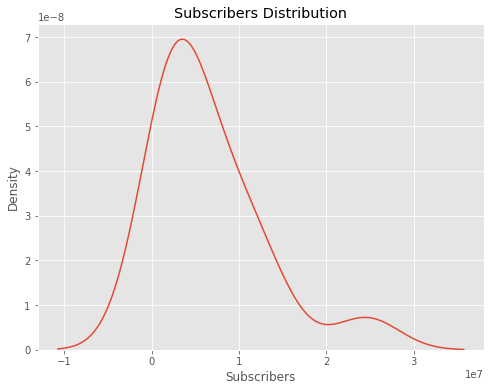

In [136]:
plt.figure(figsize=(8,6))
sns.kdeplot(df_channels['subscribers'])
plt.title('Subscribers Distribution')
plt.xlabel('Subscribers')

Text(0.5, 0, 'Views')

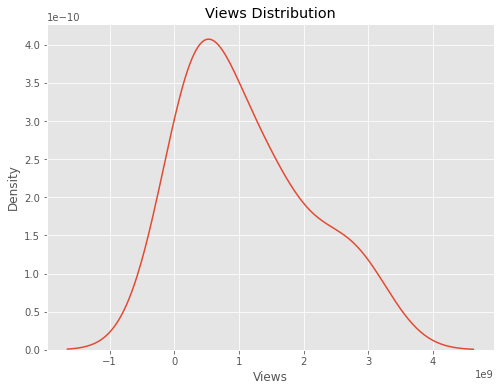

In [137]:
plt.figure(figsize=(8,6))
sns.kdeplot(df_channels['total_views'])
plt.title('Views Distribution')
plt.xlabel('Views')

Text(0.5, 0, 'Uploaded Videos')

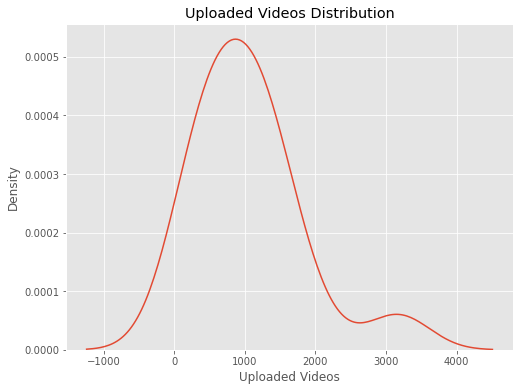

In [138]:
plt.figure(figsize=(8,6))
sns.kdeplot(df_channels['total_videos'])
plt.title('Uploaded Videos Distribution')
plt.xlabel('Uploaded Videos')

### **Bivariate Graphical Analysis**

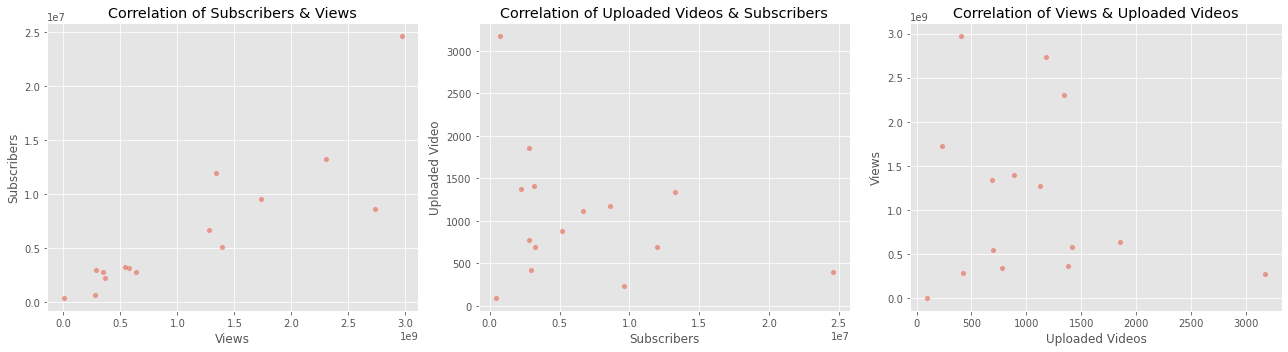

In [139]:
#pattern recognition
fig , (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize=(18, 5))

x = df_channels.total_views
y = df_channels.total_videos
z = df_channels.subscribers

ax1.scatter(x, z, s=30 , cmap='PuBuGn', edgecolor='#FFFAF0', 
            linewidth=0.5, alpha=0.5)
ax1.set_title('Correlation of Subscribers & Views')
ax1.set_xlabel('Views')
ax1.set_ylabel('Subscribers')

ax2.scatter(z, y, s=30 , cmap='PuBuGn', edgecolor='#FFFAF0', 
            linewidth=0.5, alpha=0.5)
ax2.set_title('Correlation of Uploaded Videos & Subscribers')
ax2.set_xlabel('Subscribers')
ax2.set_ylabel('Uploaded Video')

ax3.scatter(y, x, s=30 , cmap='PuBuGn', edgecolor='#FFFAF0', 
            linewidth=0.5, alpha=0.5)
ax3.set_title('Correlation of Views & Uploaded Videos')
ax3.set_xlabel('Uploaded Videos')
ax3.set_ylabel('Views')

plt.tight_layout()
plt.show()

### **Multivariate Non-graphical Analysis**

In [166]:
all_channels_mx = df_channels.corr()
all_channels_mx

,subscribers,total_views,total_videos
subscribers,1.000000,0.870050,-0.312317
total_views,0.870050,1.000000,-0.183823
total_videos,-0.312317,-0.183823,1.000000


### **Multivariate Graphical Analysis**

**Analyze Correlation Coefficients**

<AxesSubplot:>

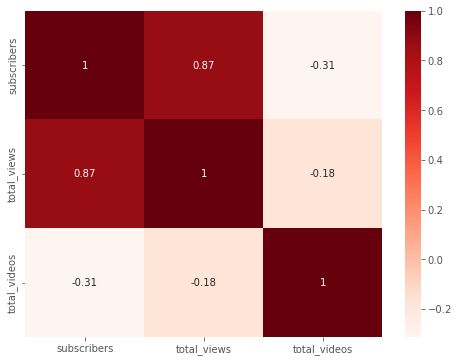

In [170]:
#association
plt.figure(figsize=(8,6))
sns.heatmap(all_channels_mx, cmap='Reds', annot=True)

There's chance of **87%** that the more  the views are , the more likely those viewers will decide to subscribe to channel..

### **Channels Details**

In [3]:
channels_data.head(2)

,Unnamed: 0,Channel_id,Channel_name,Video_id,Title,Description,Duration,Definition,Caption,Published_at,Views,Likes,Comments
0,0,UCJ48BrODPTg4RJBLNIj9J1Q,Kayla Itsines,siCR8_noqS4,"At Home, No Equipment, High Intensity Workout","Owch! This at-home, no-equipment workout is on...",PT3M2S,hd,False,2022-04-29T14:30:17Z,17954,337,0
1,1,UCJ48BrODPTg4RJBLNIj9J1Q,Kayla Itsines,5tl1yCYXCCc,How to do a Pull-Up or Chin-Up!,Want to train your body to do a pull-up or a c...,PT1M30S,hd,False,2022-04-26T14:30:03Z,5279,124,0


In [4]:
channels_data.drop(columns = ['Unnamed: 0'], inplace=True)
channels_data.sample()

,Channel_id,Channel_name,Video_id,Title,Description,Duration,Definition,Caption,Published_at,Views,Likes,Comments
5920,UCkk2vs5EXLFUMuVyhy7oOMQ,POPSUGAR,Ww5NFOm2MjE,We PRAY this gets made #littleoldwomen,'Murder Mystery 2' stars Adam Sandler and Jenn...,PT30S,hd,False,2023-04-23T14:00:20Z,6416,350,2


**Converting duration column values into readable format**

In [5]:
time_list = []

hour_pattren = re.compile(r'(\d+)H')
mins_pattren = re.compile(r'(\d+)M')
sec_pattren = re.compile(r'(\d+)S')

for val in channels_data['Duration']:
    
    hours = hour_pattren.search(val)
    mins = mins_pattren.search(val)
    secs = sec_pattren.search(val)
    
    hours = int(hours.group(1)) if hours else 0
    mins = int(mins.group(1)) if mins else 0
    secs = int(secs.group(1)) if secs else 0
    
    time = datetime.time(hours, mins, secs)
    time_list.append(str(time))
    
channels_data['Video_duration'] = [t for t in time_list]

In [6]:
channels_data['Video_duration'].loc[1:4]

1    00:01:30
2    00:01:20
3    00:03:36
4    00:22:52
Name: Video_duration, dtype: object

In [7]:
channels_data.drop(columns=['Duration'], inplace=True)
channels_data.sample()

,Channel_id,Channel_name,Video_id,Title,Description,Definition,Caption,Published_at,Views,Likes,Comments,Video_duration
10713,UCyqR7WkL8i1b6xtSssDmW9w,The Fitness Marshall,fquYjLA_f28,Finesse (Remix) - Bruno Mars | With Property B...,Check out more fun videos on guruhub.tv http:/...,hd,False,2018-03-03T18:55:35Z,735715,11323,438,00:04:53


###  **Univariate Non-graphical Analysis**

In [8]:
channels_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Views,14139.0,1.150416e+06,5.853940e+06,0.0,31385.5,170556.0,821759.5,503450854.0
Likes,14139.0,2.713280e+04,1.324969e+05,0.0,638.5,3634.0,15605.0,8660044.0
Comments,14139.0,7.613853e+02,3.370174e+03,0.0,35.0,213.0,711.0,306558.0


#### **C**oefficient **o**f **V**ariation ..

In [9]:
avg_vids_views = pd.pivot_table(channels_data, values='Views', index='Channel_name', aggfunc=np.mean)
avg_vids_views.astype(int).head(3)

,Views
Channel_name,
ATHLEAN-X™,1740141
Bradley Martyn,408369
Chloe Ting,7307676


In [10]:
std_vids_views = pd.pivot_table(channels_data, values='Views', index='Channel_name', aggfunc=np.std)
std_vids_views.astype(int).head(3)

,Views
Channel_name,
ATHLEAN-X™,2632748
Bradley Martyn,822613
Chloe Ting,28272220


In [11]:
CoV = std_vids_views / avg_vids_views
CoV.sort_values(by='Views').head(5)

,Views
Channel_name,
Pamela Reif,1.423971
ATHLEAN-X™,1.512951
Yoga With Adriene,1.682429
MattDoesFitness,1.851522
Joanna Soh Official,1.867948


In [12]:
CoV.sort_values(by='Views').tail(5)

,Views
Channel_name,
FitnessBlender,3.918672
ScottHermanFitness,3.959030
Kayla Itsines,4.508953
POPSUGAR,4.691998
XHIT Daily,5.428037


**Summary**

*Those channels on the top have a ratio of 1.5 times larger than its mean of views , it has a lower volatility in views relative to the mean compared to those on the tail..
With those on the top they can likely predict their videos views they will have when they upload new video to their channel with more certainty than those on the tail..*

In [153]:
comments_data.drop(columns = ['Unnamed: 0'], inplace=True)
comments_data.sample()

,Video_id,Comments
13234,3OCqzd_za-s,I swear down Logan won because ksi was doing ...
